## 1. Libraries

In [52]:
import pandas as pd
import regex as re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## 2. Data Analysis

In [53]:
df = pd.read_csv('./dataset/spam.csv',delimiter=',',encoding='latin-1')
df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [54]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


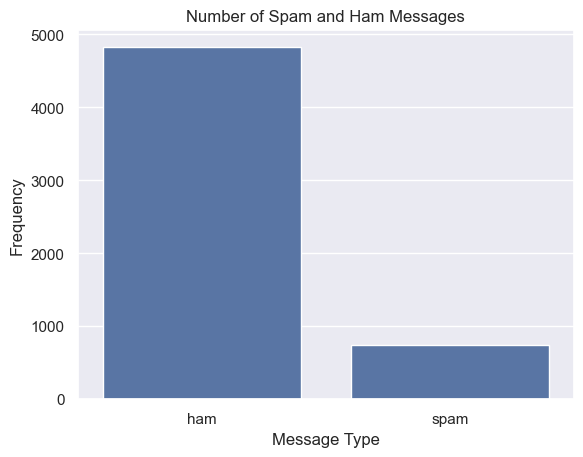

In [55]:
label_counts = df['target'].value_counts()
sns.set(style="darkgrid")
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Number of Spam and Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Frequency')
plt.show()

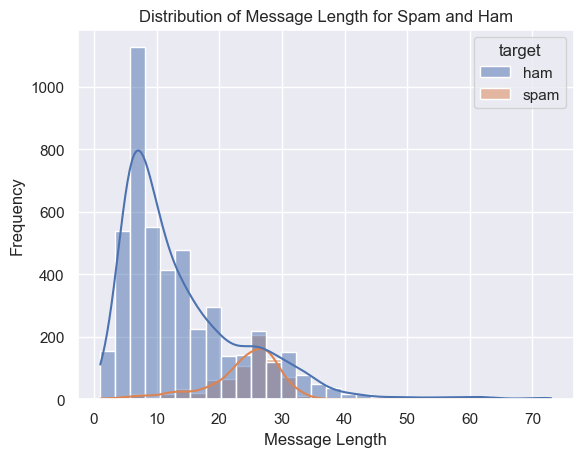

In [56]:
filtered_df = df[df['message_len'] <= 75]

length_counts = filtered_df.groupby(['message_len', 'target']).size().reset_index(name='count')

sns.histplot(data=filtered_df, x='message_len', hue='target', bins=30, kde=True)
plt.title('Distribution of Message Length for Spam and Ham')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

## 3. Data Preprocess

### Cleaning the corpus

In [57]:
def clean_text(text):
    # Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers.
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [58]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


### Clean stopwords

In [59]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


### Stemming

In [60]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


### Encoder label

In [61]:
# ham -> 0, spam -> 1
le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


### Vectorization

In [62]:
x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

5572 5572


In [63]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [64]:
# to instantiate the vectorizer
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [65]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

### Tokenization

In [66]:
# tokenize the text
texts = df['message_clean']
target = df['target_encoded']
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)
# Senquence the text
vocab_length = len(word_tokenizer.word_index) + 1
sequences = word_tokenizer.texts_to_sequences(texts)
longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
sequences_matrix = sequence.pad_sequences(sequences,maxlen=length_long_sentence)


In [67]:
sequences_matrix[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    2, 3196,
         275,  563,  530, 1011,   41,   61,  250, 1012,   89, 2233, 1013,
          17, 3197,   68]], dtype=int32)

## 4. Model

### Random Forests Document-Term Matrix

In [69]:
# Create a Random Forest model
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()

# Train the model
RF.fit(x_train_dtm, y_train)

RandomForestClassifier()

In [70]:
y_pred_class = RF.predict(x_test_dtm)
y_pred_prob = RF.predict_proba(x_test_dtm)[:, 1]

In [71]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

confusion = metrics.confusion_matrix(y_test, y_pred_class)

0.9727207465900933


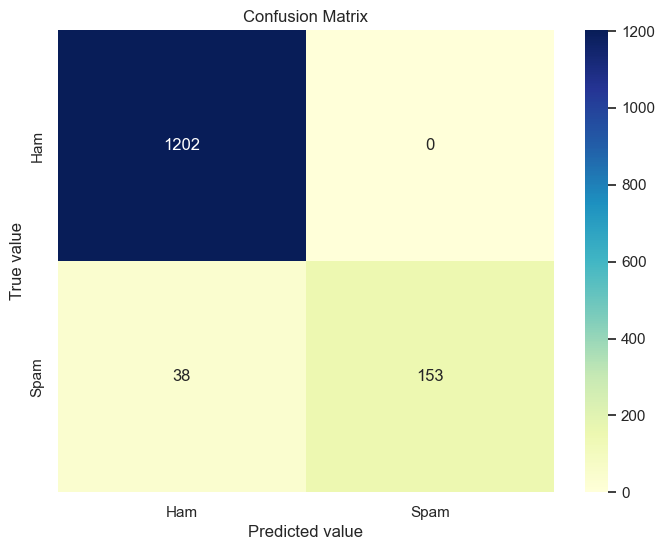

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_matrix(confusion, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted value')
    plt.ylabel('True value')
    plt.title('Confusion Matrix')
    plt.show()

labels = ['Ham', 'Spam']
plot_matrix(confusion, labels)

In [73]:
# Calculate AUC(Area Under the Curve)
metrics.roc_auc_score(y_test, y_pred_prob)

0.9768448745981828

### Random Forests

In [74]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', RandomForestClassifier())])

0.9720028715003589


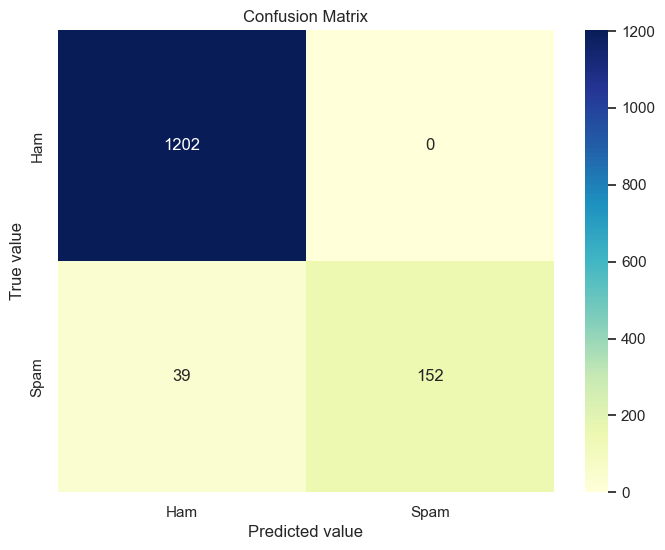

In [75]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

# Use the new plot_matrix function
labels = ['Ham', 'Spam']
plot_matrix(metrics.confusion_matrix(y_test, y_pred_class), labels)

In [76]:
from sklearn.metrics import classification_report
#  prediction Summary by species
print(classification_report(y_true=y_test,y_pred=y_pred_class))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1202
           1       1.00      0.80      0.89       191

    accuracy                           0.97      1393
   macro avg       0.98      0.90      0.94      1393
weighted avg       0.97      0.97      0.97      1393



### LSTM

In [77]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    sequences_matrix, 
    target, 
    test_size=0.15
)

In [78]:
# Evlauate functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [79]:
# Setup the RNN model
max_words = vocab_length
max_len = 80

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,100,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [80]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 80)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 80, 100)           676800    
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [81]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
147/148 [============================>.] - ETA: 0s - loss: 0.2169 - accuracy: 0.9264 - f1_m: 0.5429 - precision_m: 0.6075 - recall_m: 0.5187
Epoch 1: val_loss improved from inf to 0.09379, saving model to model.h5
148/148 [==============================] - 8s 37ms/step - loss: 0.2163 - accuracy: 0.9265 - f1_m: 0.5446 - precision_m: 0.6102 - recall_m: 0.5197 - val_loss: 0.0938 - val_accuracy: 0.9725 - val_f1_m: 0.8548 - val_precision_m: 0.8691 - val_recall_m: 0.8656 - lr: 0.0010
Epoch 2/7
148/148 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9848 - f1_m: 0.9166 - precision_m: 0.9488 - recall_m: 0.9027
Epoch 2: val_loss improved from 0.09379 to 0.08295, saving model to model.h5
148/148 [==============================] - 4s 29ms/step - loss: 0.0526 - accuracy: 0.9848 - f1_m: 0.9166 - precision_m: 0.9488 - recall_m: 0.9027 - val_loss: 0.0829 - val_accuracy: 0.9761 - val_f1_m: 0.8693 - val_precision_m: 0.9228 - val_recall_m: 0.8437 - lr: 0.0010
Epoch 3/7


### Evaluation Model

In [82]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', "{:.2f}".format(loss))
print('Test accuracy:', "{:.2f}".format(accuracy))
print('Test f1 score:', "{:.2f}".format(f1_score))
print('Test precision:', "{:.2f}".format(precision))

Test loss: 0.12
Test accuracy: 0.98
Test f1 score: 0.87
Test precision: 0.89


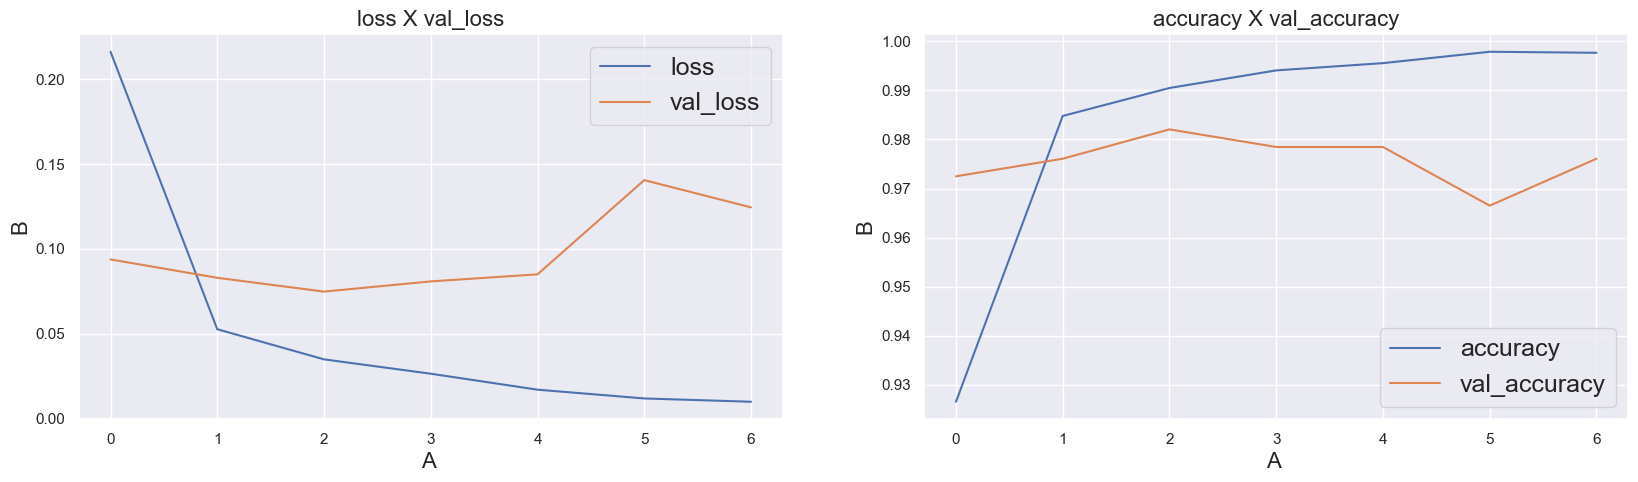

In [83]:
# Visiualize the training process
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])